<a href="https://colab.research.google.com/github/IsaacFigNewton/CSC-480/blob/main/Roomba_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Config

In [169]:
import networkx as nx
import json
import random

contents = """7
5
_#a____
___#__#
*__#_*_
_______
____*__
"""

## WorldState Class

In [204]:
class WorldState:

  def __init__(self, file_contents:str):
    self.initial_state = file_contents
    world_lst = file_contents.split("\n")
    world = {
        "cols": int(world_lst[0]),
        "rows": int(world_lst[1]),
        "grid": world_lst[2:-1]
    }
    print("Successfully loaded world:")
    print(json.dumps(world, indent=4))

    # make a grid graph of the same dims as the input world's file
    g = nx.grid_2d_graph(world["rows"], world["cols"])
    # label each node with the corresponding char from the input text
    # mark the node as clean if it's not explicitly dirty in the original file
    attribute_map = {
      n: {
        "type": world["grid"][n[0]][n[1]],
        "clean": False if world["grid"][n[0]][n[1]] == "*" else True
      } for n in g.nodes
    }
    nx.set_node_attributes(
        g,
        attribute_map
    )
    self.g = g

    # set the label and node positions so graph looks the same each iteration
    self.pos = {n:n for n in self.g.nodes}

    # initialize the bot's position in the world
    self.bot_pos = None
    for n, attrs in self.g.nodes(data=True):
      if attrs["type"] == "a":
        self.bot_pos = n
        break
    if not self.bot_pos:
      raise ValueError("No bot found in graph file provided.")

    # save an offset map
    self.offset_map = {
        "N": (0, 1),
        "S": (0, -1),
        "E": (1, 0),
        "W": (-1, 0),
        "V": (0, 0)
    }


  def copy(self):
    new_world = WorldState(self.initial_state)
    new_world.g = self.g
    new_world.pos = self.pos
    new_world.bot_pos = self.bot_pos
    return new_world


  def is_legal_move(self, move):
    if move == "V" and self.g.nodes[self.bot_pos]["clean"] == False:
      return True

    diff = self.offset_map[move]
    proposed_move = (
        self.bot_pos[0] + diff[0],
        self.bot_pos[1] + diff[1]
    )
    if proposed_move in self.g.neighbors(self.bot_pos):
        proposed_node_attributes = nx.get_node_attributes(self.g, "type")
        return proposed_node_attributes[proposed_move] != "#"
    return False


  def get_legal_moves(self):
    legal_moves = [
        move for move in self.offset_map.keys()\
        if self.is_legal_move(move)
    ]
    return legal_moves


  # get the node that has the specified offset from the bot's current location
  def get_new_pos(self, move: chr):
    if self.is_legal_move(move):
      diff = self.offset_map[move]
      return (
          self.bot_pos[0] + diff[0],
          self.bot_pos[1] + diff[1]
      )
    else:
      raise ValueError(f"invalid move '{move}' for position {self.bot_pos}")


  def move_bot_to_pos(self, new_pos: tuple):
    if self.g.nodes[self.bot_pos]["type"] != "a":
      raise KeyError(f"bot not found at node {self.bot_pos}")

    # update world tile attributes
    nx.set_node_attributes(self.g, {
        # update the type of the previous node
        # mark it as a clean tile type if it was marked as clean
        #   otherwise, mark and leave it as dirty
        self.bot_pos: {
            "type": "_" if self.g.nodes[self.bot_pos]["clean"] else "*",
            "clean": self.g.nodes[self.bot_pos]["clean"]
        },
        # update the type of the new node to indicate the bot's presence
        new_pos: {
            "type": "a",
            "clean": self.g.nodes[new_pos]["clean"]
        }
    })

    # update the bot's location being tracked
    self.bot_pos = new_pos


  def take_action(self, move:chr):
    if self.is_legal_move(move):
      # if the bot opts to vaccuum, update the attributes of its current node
      if move == "V":
        nx.set_node_attributes(self.g, {
            self.bot_pos: {
                "type": self.g.nodes[self.bot_pos]["type"],
                "clean": True
            }
        })
      else:
        self.move_bot_to_pos(self.get_new_pos(move))
    else:
      raise ValueError(f"invalid move '{move}' for position {self.bot_pos}")


  def random_walk(self):
    nodes_generated = 0
    nodes_expanded = 0
    # while not all the tiles are marked as 'clean'
    while not all(nx.get_node_attributes(self.g, "clean").values()):
      legal_moves = self.get_legal_moves()
      selected_move = legal_moves[random.randint(0, len(legal_moves)-1)]
      nodes_generated += len(legal_moves)
      nodes_expanded += 1
      print(selected_move)
      self.take_action(selected_move)
    print(nodes_generated)
    print(nodes_expanded)


  def dfs(self):
      nodes_generated = 0
      nodes_expanded = 0

      # Use a stack for DFS: (position, path_taken)
      stack = [(self.bot_pos, [])]
      visited = set()

      while stack and not all(nx.get_node_attributes(self.g, "clean").values()):
          current_pos, path = stack.pop()
          visited.add(current_pos)
          nodes_expanded += 1

          # Explore neighbors or vaccuum
          for move in ["N", "S", "E", "W", "V"]:
              if self.is_legal_move(move):
                  new_pos = self.get_new_pos(move)
                  if new_pos not in visited:
                      copy = self.copy()
                      self.take_action(move)
                      stack.append((new_pos, path + [move]))
                      nodes_generated += 1

      print(path)
      print(nodes_generated)
      print(nodes_expanded)


  def draw(self):
    nx.draw(
      self.g,
      pos=self.pos
    )
    nx.draw_networkx_labels(
        self.g,
        pos=self.pos,
        labels={n: self.g.nodes[n]["type"] for n in self.g.nodes}
    )

# Test WorldState Creation

Successfully loaded world:
{
    "cols": 7,
    "rows": 5,
    "grid": [
        "_#a____",
        "___#__#",
        "*__#_*_",
        "_______",
        "____*__"
    ]
}


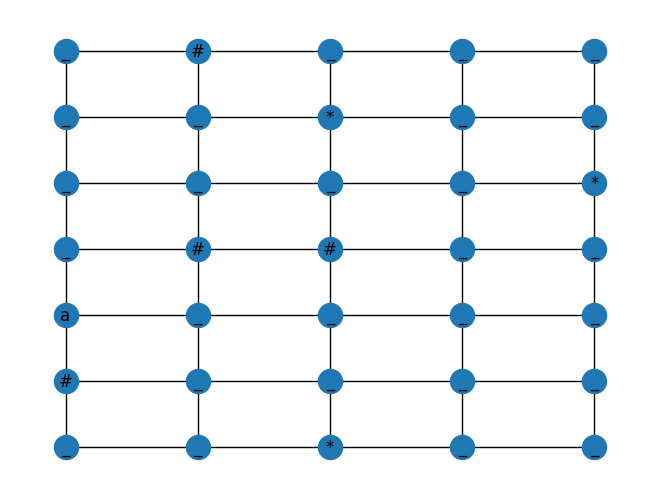

In [200]:
world = WorldState(contents)
world.draw()

In [201]:
world.dfs()

['N']
3
4


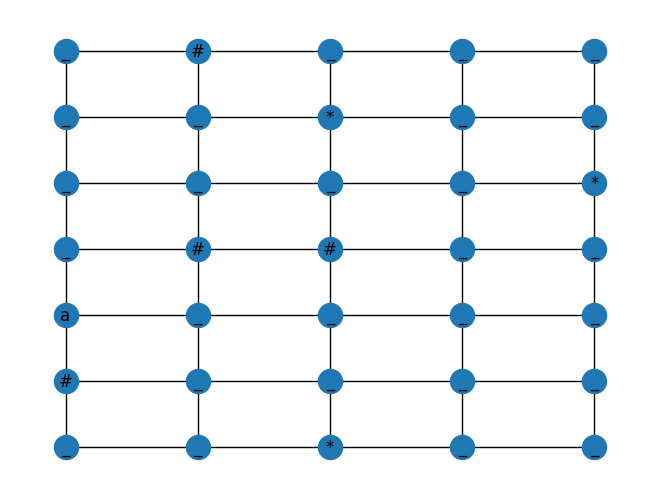

In [202]:
world.draw()